In [1]:
import os
import ee
import geopandas as gpd
import numpy as np

import rasterio
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.exposure import rescale_intensity

from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm

In [2]:
from src.data.fetch import (
    dem_from_tnm,
    landtrendr_from_gee,
    s2_from_gee,
    nlcd_from_mrlc,
)
from src.visualization.utils import colorize_nlcd

In [3]:
SERVICE_ACCOUNT = "forest-mapping@forest-mapping.iam.gserviceaccount.com"
credentials = ee.ServiceAccountCredentials(
    SERVICE_ACCOUNT, "../forest-mapping-gee.json"
)
ee.Initialize(credentials)

In [4]:
tiles = gpd.read_file("../data/interim/washington_quarter_quads.shp")
tiles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    5772 non-null   int64   
 1   CELL_ID     5772 non-null   int64   
 2   CELL_NAME   5772 non-null   object  
 3   PRIMARY_ST  5772 non-null   object  
 4   CELL_MAPCO  5772 non-null   object  
 5   CELL_TYPE   5772 non-null   int64   
 6   CELL_ALLWA  5772 non-null   int64   
 7   CELL_DESCR  4 non-null      object  
 8   CELL_DIACR  0 non-null      object  
 9   GLOBALID    5772 non-null   object  
 10  SHAPE_Leng  5772 non-null   float64 
 11  SHAPE_Area  5772 non-null   float64 
 12  geometry    5772 non-null   geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 586.3+ KB


In [5]:
tiles.crs

<Projected CRS: EPSG:2927>
Name: NAD83(HARN) / Washington South (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Washington - counties of Adams; Asotin; Benton; Clark; Columbia; Cowlitz; Franklin; Garfield; Grant south of approximately 47°30'N; Grays Harbor; Kittitas; Klickitat; Lewis; Mason; Pacific; Pierce; Skamania; Thurston; Wahkiakum; Walla Walla; Whitman; Yakima.
- bounds: (-124.4, 45.54, -116.91, 47.61)
Coordinate Operation:
- name: SPCS83 Washington South zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## An Illustrative Example
For a single tile, fetch the SENTINEL-2, LandTrendr, DEM, and NLCD imagery and plot it.

In [6]:
tile = tiles.sample(1)
bbox = tile.iloc[0]["geometry"].bounds
epsg = tiles.crs.to_epsg()
tile.iloc[0]

OBJECTID                                                    845
CELL_ID                                                  305391
CELL_NAME                                             Valley NE
PRIMARY_ST                                           Washington
CELL_MAPCO                                             48117-B6
CELL_TYPE                                                     1
CELL_ALLWA                                                    2
CELL_DESCR                                                 None
CELL_DIACR                                                 None
GLOBALID                 {87256A29-E598-4BE6-AC72-709D55F12C4A}
SHAPE_Leng                                                 0.25
SHAPE_Area                                             0.003906
geometry      POLYGON ((2341818.9870122834 1053771.942736826...
Name: 844, dtype: object

In [7]:
%%time
s2_ras, s2_profile = s2_from_gee(bbox, 2022, epsg, scale=10)
width, height = s2_profile['width'], s2_profile['height']

CPU times: user 147 ms, sys: 18.4 ms, total: 166 ms
Wall time: 32.9 s


In [8]:
%%time
lt_ras, lt_profile = landtrendr_from_gee(bbox, 2022, epsg, scale=30)
lt_ras = resize(lt_ras, (lt_ras.shape[0], height, width), order=0, preserve_range=True)

CPU times: user 4.06 s, sys: 0 ns, total: 4.06 s
Wall time: 1min 20s


In [9]:
%%time
dem = dem_from_tnm(bbox, width=width, height=height, inSR=epsg, pixelType='S16')

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 880 ms


In [10]:
%%time
nlcd = nlcd_from_mrlc(bbox, width=width, height=height, layer='NLCD_2019_Land_Cover_L48', inSR=epsg)
nlcd_color = colorize_nlcd(nlcd)

CPU times: user 52.2 ms, sys: 2.18 ms, total: 54.4 ms
Wall time: 1.04 s


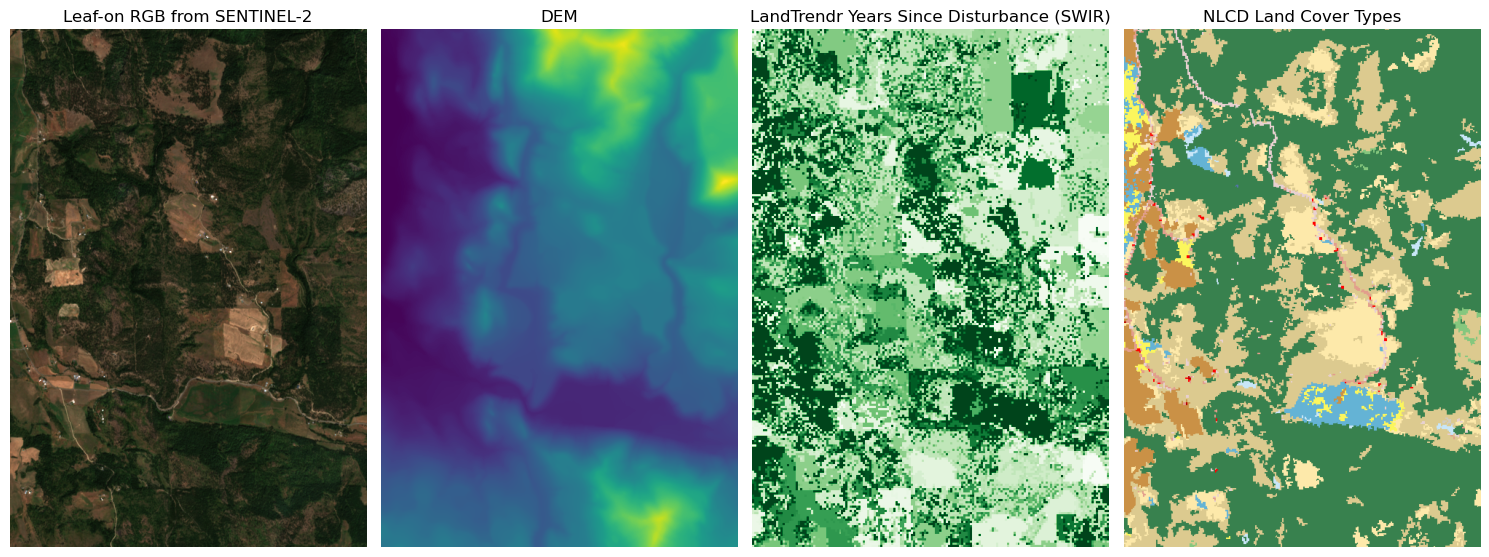

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(15, 10))
axs[0].imshow(
    rescale_intensity(
        np.dstack((s2_ras[2], s2_ras[1], s2_ras[0])),
        in_range=(0, 3000),
        out_range="uint8",
    ).astype("uint8")
)
axs[1].imshow(dem)
axs[2].imshow(np.ma.masked_equal(lt_ras[0], -32768), cmap="Greens")
axs[3].imshow(nlcd_color)
for ax in axs.ravel():
    ax.axis("off")
axs[0].set_title("Leaf-on RGB from SENTINEL-2")
axs[1].set_title("DEM")
axs[2].set_title("LandTrendr Years Since Disturbance (SWIR)")
axs[3].set_title("NLCD Land Cover Types")
plt.tight_layout()
plt.show()

## Download Data for Tiles
With a helper function to download images, we'll iterate through all the tiles and fetch the data with some parallel processing.

In [12]:
def download_images(
    gdf_row,
    out_dir="../data/interim/washington_imagery",
    overwrite=False,
    epsg=2927,
    year=2022,
    get_landtrendr=True,
    nlcd_layer="NLCD_2019_Land_Cover_L48",
):
    bbox = gdf_row["geometry"].bounds
    cell_id = gdf_row["CELL_ID"]

    # get sentinel image and save to disk
    out_s2 = os.path.join(out_dir, "sentinel", f"{cell_id}_sentinel{year}.tif")
    try:
        if not os.path.exists(out_s2) or overwrite:
            s2_ras, s2_profile = s2_from_gee(bbox, year, epsg, scale=10)
            s2_profile.update(compress="LZW")

            with rasterio.open(out_s2, "w", **s2_profile) as dst:
                for i, band in enumerate(s2_ras):
                    dst.write(band, i + 1)

        with rasterio.open(out_s2) as src:
            width, height, trf, crs = src.width, src.height, src.transform, src.crs
    except Exception as e:
        print("Failed sentinel on", cell_id, e)
        return cell_id

    out_lt = os.path.join(out_dir, "landtrendr", f"{cell_id}_landtrendr{year}.tif")
    try:
        if (not os.path.exists(out_lt) or overwrite) and get_landtrendr:
            lt_ras, lt_profile = landtrendr_from_gee(bbox, year, epsg, scale=30)
            lt_ras = resize(
                lt_ras, (lt_ras.shape[0], height, width), order=0, preserve_range=True
            )
            lt_profile.update(width=width, height=height, transform=trf, compress="LZW")

            with rasterio.open(out_lt, "w", **lt_profile) as dst:
                for i, band in enumerate(lt_ras):
                    dst.write(band, i + 1)
    except Exception as e:
        print("Failed landtrendr on", cell_id, e)

    # get dem, enforce same size as sentinel image
    out_dem = os.path.join(out_dir, "dem", f"{cell_id}_dem.tif")
    if not os.path.exists(out_dem) or overwrite:
        dem = dem_from_tnm(bbox, width=width, height=height, inSR=epsg, pixelType="S16")
        dem_profile = {
            "driver": "GTiff",
            "dtype": "int16",
            "nodata": -32768.0,
            "width": width,
            "height": height,
            "count": 1,
            "crs": crs,
            "transform": trf,
            "blockxsize": 256,
            "blockysize": 256,
            "tiled": True,
            "compress": "LZW",
            "interleave": "pixel",
        }
        with rasterio.open(out_dem, "w", **dem_profile) as dst:
            dst.write(dem, 1)

    # get nlcd, enforce same size as sentinel image
    nlcd_year = nlcd_layer.split("_")[1]
    out_nlcd = os.path.join(out_dir, "nlcd", f"{cell_id}_nlcd{nlcd_year}.tif")
    if not os.path.exists(out_nlcd) or overwrite:
        nlcd = nlcd_from_mrlc(
            bbox, width=width, height=height, layer=nlcd_layer, inSR=epsg
        )
        nlcd_profile = {
            "driver": "GTiff",
            "dtype": "uint8",
            "nodata": 0,
            "width": width,
            "height": height,
            "count": 1,
            "crs": crs,
            "transform": trf,
            "blockxsize": 256,
            "blockysize": 256,
            "tiled": True,
            "compress": "LZW",
            "interleave": "pixel",
        }
        with rasterio.open(out_nlcd, "w", **nlcd_profile) as dst:
            dst.write(nlcd, 1)
            dst.write_colormap(
                1,
                {
                    0: [0, 0, 0],  # nodata
                    11: [84, 117, 168],  # open water
                    12: [255, 255, 255],  # perennial ice and snow
                    21: [232, 209, 209],  # developed, open space
                    22: [226, 158, 140],  # developed, low intensity
                    23: [255, 0, 0],  # developed, medium intensity
                    24: [181, 0, 0],  # developed, high intensity
                    31: [210, 205, 192],  # barren land (rock/sand/clay)
                    41: [133, 199, 126],  # deciduous forest
                    42: [56, 129, 78],  # evergreen forest
                    43: [212, 231, 176],  # mixed forest
                    51: [175, 150, 60],  # dwarf scrub
                    52: [220, 202, 143],  # shrub/scrub
                    71: [253, 233, 170],  # grassland/herbaceous
                    72: [209, 209, 130],  # sedge/herbaceous
                    73: [163, 204, 81],  # lichens
                    74: [130, 186, 158],  # moss
                    81: [251, 246, 93],  # pasture/hay
                    82: [202, 145, 70],  # cultivated crops
                    90: [200, 230, 248],  # woody wetlands
                    95: [100, 179, 213],  # emergent herbaceous wetlands
                },
            )

    return cell_id

In [13]:
to_run = [row for _, row in tiles[["geometry", "CELL_ID"]].iterrows()]
to_run[0]["CELL_ID"]

221799

In [14]:
OUT_DIR = "../data/interim/washington_imagery"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "sentinel"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "landtrendr"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "dem"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "nlcd"), exist_ok=True)

In [15]:
with ProcessPoolExecutor(32) as executor:
    completed = []
    jobs = [executor.submit(download_images, row) for row in to_run]

    for job in tqdm(as_completed(jobs), total=len(jobs)):
        completed.append(job.result())

  0%|          | 0/5772 [00:00<?, ?it/s]